In [ ]:
%%capture
%run '/content/drive/MyDrive/Federated_Learning/CIFAR-10/CIFAR-10_NonIID/PathologicalPartition/Decentralized/Pathological_Requirement.ipynb'

In [ ]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images,labels=batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            if images.size(0)<=1:
                continue
            else:
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                total += labels.size(0)
                correct += (torch.max(outputs.data,1)[1]==labels).sum().item()

        if total>0:
            epoch_loss /= total
            epoch_acc = correct / total
            if verbose:
                print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

In [ ]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    print(f"Context data: {context.__dict__}")

    partition_id = int(context.node_id) % NUM_CLIENTS if hasattr(context, 'node_id') else 0
    if hasattr(context, 'node_config') and 'partition_id' in context.node_config:
        partition_id = context.node_config['partition_id']

    print(f"Using partition_id: {partition_id}")
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
from flwr.server.strategy import FedAvgM # Federated average with momentum

test_accuracies = []

class CustomFedAvgM(FedAvgM):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
params = get_parameters(Net())
from flwr.common import ndarrays_to_parameters

In [ ]:
strategy = CustomFedAvgM(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    initial_parameters=ndarrays_to_parameters(params),
    server_learning_rate=1.0, # Learning rate
    server_momentum=0.9 # Momentum
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=1543) 2025-04-28 15:38:30.683352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1543) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1543) E0000 00:00:1745854710.727883    1543 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1543) E0000 00:00:1745854710.740033    1543 cuda_bla

(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


Generating train split:  29%|██▊       | 14300/50000 [00:00<00:00, 71426.10 examples/s]
(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=1542) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=1542) see the appropriate new directories, set the environment variable
(ClientAppActor pid=1542) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=1542) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=1542)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 107147.89 examples/s]
(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to 

(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1
(ClientApp

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 9 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 9 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 9 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 9 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 test size: 501 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Test Accuracy: 0.1559
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 5 size: 2500 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 5 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 5 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id':

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6
(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3
(ClientAp

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4
(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5
(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 6 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0
(ClientAppActor pid=1543) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 0 test size: 501 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Test Accuracy: 0.3347
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1542) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 train size: 4000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 test size: 1000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 9


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5
(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1543) Using partition_id: 2 [repeated 3x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Partition 2 size: 3334 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 2 train size: 2667 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 2 test size: 667 [repeated 3x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Accuracy: 0.1421
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 9
(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 9 size: 2499
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 3 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 1 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 train size: 4000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 test size: 1000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 test size: 501 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Test Accuracy: 0.1640
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 1 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 train size: 4000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 test size: 1000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5
(ClientApp

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(
(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 9


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 9 size: 2499 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 9 train size: 1999 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 9 test size: 500 [repeated 3x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Test Accuracy: 0.2320
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5
(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 3


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 9


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 9 size: 2499
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 3 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Partition 4 size: 2501 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 4 train size: 2000 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 4 test size: 501 [repeated 3x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 0 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Accuracy: 0.1801


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 5 size: 2500 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 5 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 5 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientA

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Partition 4 size: 2501 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 4 train size: 2000 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 4 test size: 501 [repeated 3x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Test Accuracy: 0.2939


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 52185945217

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 3


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 3
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 3 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0
(ClientAppActor pid=1542) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 test size: 501 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Accuracy: 0.3025
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 3 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 3 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 test size: 501 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Test Accuracy: 0.3548
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1543) Using partition_id: 3 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 train size: 4000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 test size: 1000 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2
(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5
(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 0 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 test size: 501 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 10: Test Accuracy: 0.2973
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 5 size: 2500 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 5 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 5 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-i

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6
(ClientAppActor pid=1542) Partition 9 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 9 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 9 test size: 500 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0
(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 3


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 9
(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_r

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 9 size: 2499
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1543) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 test size: 501 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 11: Test Accuracy: 0.4683
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 1 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(
(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 9 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 9 size: 2499
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1543) Using partition_id: 3 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 9 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 9 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 9 test size: 500 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6
(ClientAppActor pid=1542) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 6 test size: 667 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 12: Test Accuracy: 0.4048
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 9


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 9 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 3 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 3 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 2 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pi

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1543) Using partition_id: 4 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 2 size: 3334 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 2 train size: 2667 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 2 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 test size: 501 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 13: Test Accuracy: 0.3298
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1543) Partition 5 size: 2500 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 5 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 5 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 1 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 train size: 4000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 test size: 1000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 3 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor 

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 3 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 0 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 14: Test Accuracy: 0.3686
(ClientAppActor pid=1542) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 train size: 4000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 test size: 1000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, '

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6
(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 9


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) 
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) 

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 test size: 501 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 15: Test Accuracy: 0.2526
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 9
(ClientAppActor pid=1542) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 train size: 4000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 test size: 1000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pi

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1
(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(
(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1543) Using partition_id: 2 [repeated 3x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Partition 2 size: 3334 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 2 train size: 2667 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 2 test size: 667 [repeated 3x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 16: Test Accuracy: 0.3150
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 3


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1542) Using partition_id: 4 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0
(ClientAppActor pid=1542) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 test size: 501 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 17: Test Accuracy: 0.3716
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5
(ClientAppActor pid=1542) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) 
(ClientAppActor pid=1542) Partition 9 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 9 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 9 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 3


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 size: 5000 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 1 train size: 4000 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 1 test size: 1000 [repeated 3x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 4x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 3 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 18: Test Accuracy: 0.2819
(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 9 size: 2499
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2
(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0
(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1
(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(
(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0
(ClientAppActor pid=1542) Partition 4 size: 2501 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 4 train size: 2000 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 4 test size: 501 [repeated 3x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 19: Test Accuracy: 0.3378
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1
(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501
(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 9 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1543) Using partition_id: 6 [repeated 3x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 9 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 9 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 9 test size: 500 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(
(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 20: Test Accuracy: 0.2632
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5
(ClientAppActor pid=1542) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(
(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 5 size: 2500 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 5 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 5 test size: 500 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 3 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0
(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 9


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 0 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 5 size: 2500 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 5 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 5 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 9 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 21: Test Accuracy: 0.4149
(ClientAppActor pid=1542) Partition 9 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 9 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 9 test size: 500 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'st

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6
(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4
(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 9


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1542) Partition 4 size: 2501 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 4 train size: 2000 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 4 test size: 501 [repeated 3x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 22: Test Accuracy: 0.4117
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 3 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 3 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 2 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 2 size: 3334 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 2 train size: 2667 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 2 test size: 667 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 23: Test Accuracy: 0.3556
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id':

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 3


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 9


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4
(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 9
(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 3


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 test size: 501 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 24: Test Accuracy: 0.3030
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1
(ClientAppActor pid=1542) Partition 5 size: 2500 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 5 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 5 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 9


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 9 size: 2499
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 1 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 train size: 4000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 test size: 1000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 6 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 6 test size: 667 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 25: Test Accuracy: 0.2047
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 9


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 9
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4
(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 9 size: 2499
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Test Accuracy: 0.2636
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 0 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 9
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6
(ClientA

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2
(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 3 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 3 size: 3333 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 3 train size: 2666 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 3 test size: 667 [repeated 3x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 27: Test Accuracy: 0.2484


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(
(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 9 size: 2499
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 93131394488

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 3


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 4 size: 2501 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 4 train size: 2000 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 4 test size: 501 [repeated 3x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 28: Test Accuracy: 0.2272
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 9 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0
(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6
(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1543) Using partition_id: 6 [repeated 3x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Partition 6 size: 3333 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 9 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 9 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 29: Test Accuracy: 0.2621
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4
(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 2 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 size: 2501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 3 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 3 size: 3333


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 9


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 9
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 9 size: 2499
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 3 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 30: Test Accuracy: 0.2678
(ClientAppActor pid=1543) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 0 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 1 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 train size: 4000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 test size: 1000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 3 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 0 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 test size: 501 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 31: Test Accuracy: 0.1791
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 9
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5
(ClientAppActor pid=1543) Partition 9 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 train size: 1999 [

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1542) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor p

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor 

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 test size: 501 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 32: Test Accuracy: 0.1883
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1
(ClientAppActor pid=1543) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 train size: 4000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 test size: 1000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 9


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6
(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 3


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1542) Using partition_id: 4 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 4 size: 2501 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 4 train size: 2000 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 4 test size: 501 [repeated 3x across cluster]
(ClientA

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 33: Test Accuracy: 0.3433
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1
(ClientAppActor pid=1542) Partition 5 size: 2500 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 5 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 5 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 9


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 9 size: 2499
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 9 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 9 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 9 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 9 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 0 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 34: Test Accuracy: 0.2236
(ClientAppActor pid=1542) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1542) Using partition_id: 9 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3
(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0
(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6
(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 6 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 4 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 35: Test Accuracy: 0.2882
(ClientAppActor pid=1543) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'st

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 3
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 9


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2
(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 9
(ClientAppActor pid=1543) Partition 9 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 36: Test Accuracy: 0.3842
(ClientAppActor pid=1542) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 6 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 1 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 train size: 4000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 test size: 1000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 9 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6
(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2
(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 3 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 3 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 0 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 37: Test Accuracy: 0.1891
(ClientAppActor pid=1543) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 0 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 train size: 4000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 test size: 1000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, '

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 3
(ClientAppActor pid=1543) Partition 9 size: 2499
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5
(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1
(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 9
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3
(ClientA

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 38: Test Accuracy: 0.1830
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5
(ClientAppActor pid=1542) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   con

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 9
(ClientAppActor pid=1542) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor 

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 3 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2
(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6
(ClientA

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 39: Test Accuracy: 0.1518
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5
(ClientAppActor pid=1543) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   conf

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 train size: 4000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 test size: 1000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 9
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_reco

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3
(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 9
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3
(Client

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 40: Test Accuracy: 0.1661
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 1 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 4 size: 2501 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 4 train size: 2000 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 4 test size: 501 [repeated 3x across cluster]
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 9 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0
(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3
(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1
(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 9


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 9 size: 2499
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1542) Using partition_id: 4 [repeated 3x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1542) Partition 4 size: 2501 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 4 train size: 2000 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 4 test size: 501 [repeated 3x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 41: Test Accuracy: 0.1732
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5
(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 3


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 9
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0
(ClientA

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5
(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 9 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 test size: 500 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 4 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 42: Test Accuracy: 0.3594


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 1 size: 5000 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 1 train size: 4000 [repeated 3x across cluster]
(ClientAppActor pid=1542) Partition 1 test size: 1000 [repeated 3x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500
(ClientA

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 9 size: 2499
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 3


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0
(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2
(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5
(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 3 test size: 667 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 43: Test Accuracy: 0.3193
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5
(ClientAppActor pid=1543) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 9 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 train size: 4000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 test size: 1000 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6
(ClientAppActor pid=1543) Partition 9 size: 2499
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4
(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1
(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3
(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 0 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 44: Test Accuracy: 0.3078
(ClientAppActor pid=1542) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'st

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6
(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) 
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) 
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 9
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 9 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 45: Test Accuracy: 0.1227
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1
(ClientAppActor pid=1543) Partition 2 size: 3334 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 2 train size: 2667 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 2 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 train size: 4000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 test size: 1000 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 2 size: 3334 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 2 train size: 2667 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 2 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 0 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 9 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 3 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 3 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 3 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1542) Using partition_id: 6 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 9 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 test size: 500 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 46: Test Accuracy: 0.2110
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5
(ClientAppActor pid=1543) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 train size: 4000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 test size: 1000 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 9
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 0 size: 2501
(ClientAppActor pid=1543) Partition 0 train size: 2000
(ClientAppActor pid=1543) Partition 0 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 3


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1543) Using partition_id: 3 [repeated 3x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 1 size: 5000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 train size: 4000 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 1 test size: 1000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 47: Test Accuracy: 0.0991
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5
(ClientAppActor pid=1543) Partition 5 size: 2500
(ClientAppActor pid=1543) Partition 5 train size: 2000
(ClientAppActor pid=1543) Partition 5 test size: 500
(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 6


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 6 size: 3333
(ClientAppActor pid=1542) Partition 6 train size: 2666
(ClientAppActor pid=1542) Partition 6 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 3


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 3 size: 3333
(ClientAppActor pid=1543) Partition 3 train size: 2666
(ClientAppActor pid=1543) Partition 3 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4
(ClientA

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 9


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 9 size: 2499
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 9 size: 2499
(ClientAppActor pid=1542) Partition 9 train size: 1999
(ClientAppActor pid=1542) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1543) Using partition_id: 4 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 4 size: 2501 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 4 train size: 2000 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 4 test size: 501 [repeated 3x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 4x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 0


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 48: Test Accuracy: 0.2095
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4
(ClientAppActor pid=1543) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 test size: 501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pi

(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Partition 9 size: 2499
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 6 [repeated 2x across cluster]
(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 4
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 3469466445658837381, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 1
(ClientA

(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Partition 1 size: 5000
(ClientAppActor pid=1542) Partition 1 train size: 4000
(ClientAppActor pid=1542) Partition 1 test size: 1000
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 2


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1543) Partition 2 size: 3334
(ClientAppActor pid=1543) Partition 2 train size: 2667
(ClientAppActor pid=1543) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 12490327705000113244, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 9 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 9 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 4 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 49: Test Accuracy: 0.2068
(ClientAppActor pid=1543) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=1542)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 11169890011074838009, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1543) Using partition_id: 9 [repeated 3x across cluster]
(ClientAppActor pid=1543) Partition 4 size: 2501 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 train size: 2000 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 4 test size: 501 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 9313139448818748123, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 3
(ClientAppActor pid=1543) Partition 9 size: 2499
(ClientAppActor pid=1543) Partition 9 train size: 1999
(ClientAppActor pid=1543) Partition 9 test size: 500
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 6


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 3 size: 3333
(ClientAppActor pid=1542) Partition 3 train size: 2666
(ClientAppActor pid=1542) Partition 3 test size: 667


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 7187383116799632190, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 0
(ClientAppActor pid=1543) Partition 6 size: 3333
(ClientAppActor pid=1543) Partition 6 train size: 2666
(ClientAppActor pid=1543) Partition 6 test size: 667
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5635232644346814794, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 4


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 0 size: 2501
(ClientAppActor pid=1542) Partition 0 train size: 2000
(ClientAppActor pid=1542) Partition 0 test size: 501


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5753579868238737372, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 2
(ClientAppActor pid=1543) Partition 4 size: 2501
(ClientAppActor pid=1543) Partition 4 train size: 2000
(ClientAppActor pid=1543) Partition 4 test size: 501
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 1


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 2 size: 3334
(ClientAppActor pid=1542) Partition 2 train size: 2667
(ClientAppActor pid=1542) Partition 2 test size: 667


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1543)   warnings.warn(


(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1542)   array_records={},
(ClientAppActor pid=1542)   metric_records={},
(ClientAppActor pid=1542)   config_records={}
(ClientAppActor pid=1542) ), 'run_config': {}}
(ClientAppActor pid=1542) Using partition_id: 5
(ClientAppActor pid=1543) Partition 1 size: 5000
(ClientAppActor pid=1543) Partition 1 train size: 4000
(ClientAppActor pid=1543) Partition 1 test size: 1000


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 5 size: 2500
(ClientAppActor pid=1542) Partition 5 train size: 2000
(ClientAppActor pid=1542) Partition 5 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 540618181922794435, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1543)   array_records={},
(ClientAppActor pid=1543)   metric_records={},
(ClientAppActor pid=1543)   config_records={}
(ClientAppActor pid=1543) ), 'run_config': {}}
(ClientAppActor pid=1543) Using partition_id: 5


(ClientAppActor pid=1542) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1542)   warnings.warn(


(ClientAppActor pid=1542) Partition 4 size: 2501
(ClientAppActor pid=1542) Partition 4 train size: 2000
(ClientAppActor pid=1542) Partition 4 test size: 501
(ClientAppActor pid=1542) Context data: {'run_id': 4705851381446203645, 'node_id': 5218594521757967131, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1542)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1542)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1542) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1542) Using partition_id: 1 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=1543) Partition 9 size: 2499 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 train size: 1999 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 9 test size: 500 [repeated 2x across cluster]
(ClientAppActor pid=1543) Context data: {'run_id': 4705851381446203645, 'node_id': 16649802248687963806, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1543)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1543)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1543) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1543) Using partition_id: 6 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 10262.78s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06639826845137257
INFO :      		round 2: 0.05488927508321744
INFO :      		round 3: 0.13496843169347247
INFO :      		round 4: 0.12239027009434579
INFO :      		round 5: 0.11130697178739854
INFO :      		round 6: 0.08916379444638377
INFO :      		round 7: 0.06324286700679138
INFO :      		round 8: 0.07418419662353186
INFO :      		round 9: 0.05990595289475716
INFO :      		round 10: 0.05504128988049882
INFO :      		round 11: 0.04752216214326763
INFO :      		round 12: 0.05228011829248565
INFO :      		round 13: 0.05675510383086943
INFO :      		round 14: 0.047261982629608866
INFO :      		round 15: 0.06998515571564329
INFO :      		round 16: 0.06786943125883702
INFO :      		round 17: 0.05806768648257988
INFO :      		round 18: 0.0605427428561629
INFO :      		round 19: 

Round 50: Test Accuracy: 0.3470
(ClientAppActor pid=1543) Partition 6 size: 3333 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 6 train size: 2666 [repeated 2x across cluster]
(ClientAppActor pid=1543) Partition 6 test size: 667 [repeated 2x across cluster]


(ClientAppActor pid=1543) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=1543)   warnings.warn( [repeated 2x across cluster]


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.1559
Round 2: 0.3347
Round 3: 0.1421
Round 4: 0.1640
Round 5: 0.2320
Round 6: 0.1801
Round 7: 0.2939
Round 8: 0.3025
Round 9: 0.3548
Round 10: 0.2973
Round 11: 0.4683
Round 12: 0.4048
Round 13: 0.3298
Round 14: 0.3686
Round 15: 0.2526
Round 16: 0.3150
Round 17: 0.3716
Round 18: 0.2819
Round 19: 0.3378
Round 20: 0.2632
Round 21: 0.4149
Round 22: 0.4117
Round 23: 0.3556
Round 24: 0.3030
Round 25: 0.2047
Round 26: 0.2636
Round 27: 0.2484
Round 28: 0.2272
Round 29: 0.2621
Round 30: 0.2678
Round 31: 0.1791
Round 32: 0.1883
Round 33: 0.3433
Round 34: 0.2236
Round 35: 0.2882
Round 36: 0.3842
Round 37: 0.1891
Round 38: 0.1830
Round 39: 0.1518
Round 40: 0.1661
Round 41: 0.1732
Round 42: 0.3594
Round 43: 0.3193
Round 44: 0.3078
Round 45: 0.1227
Round 46: 0.2110
Round 47: 0.0991
Round 48: 0.2095
Round 49: 0.2068
Round 50: 0.3470



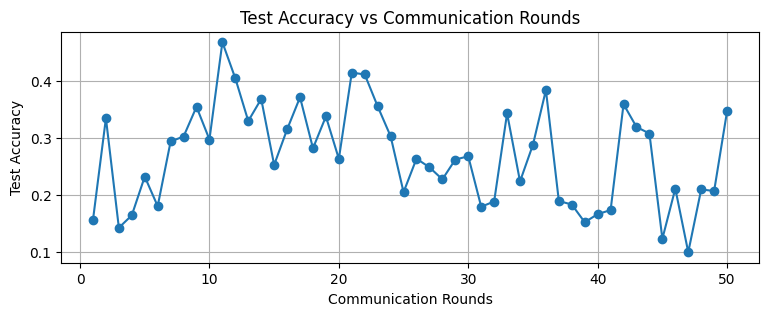

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()